# Test Semi-Supervised Hyperspectral Image Classification via Spatial-Regulated Self-Training

1. Import dependencies

In [1]:
import random
import torch
import numpy as np
import multiprocessing

from IPython.display import HTML

from torch import nn

from src.util.torch_device import resolve_torch_device
from src.data.indian_pines import load_indian_pines
from src.pipeline.spatial_regulated_self_training_pipeline import (
    SpatialRegulatedSelfTrainingPipeline,
    SpatialRegulatedSelfTrainingPipelineArgs,
    KMeansClustering,
    CnnFeatureExtractor,
    MultipleCnnFeatureExtractor,
    FlatteningFeatureExtractor,
)
from src.trainer.classification_trainer import ClassificationTrainer
from src.model.fully_convolutional_lenet import FullyConvolutionalLeNet
from src.util.semi_guided import sample_from_segmentation_matrix
from src.visualization.plot import plot_segmentation_comparison
from src.util.over_clustering import exponential_decay_over_clustering
from src.visualization.plot import (
    plot_loss,
    plot_f1_score,
    plot_overall_accuracy,
    plot_average_accuracy,
    plot_kappa,
    plot_extracted_features_by_epoch,
    plot_clusters_by_epoch,
    plot_semantic_constraints_by_epoch,
    plot_merged_semantic_constraint_by_epoch,
    plot_predictions_by_epoch,
    plot_k_values,
)

2. Prepare env

In [2]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

generator = torch.Generator()
generator.manual_seed(random_seed)

In [3]:
f"Device is {device}"

'Device is mps'

# Indian pines

0. Set params

In [4]:
splits = 4
learning_rate = 1e-3
patch_size = 9
num_epochs = 11
feature_extractor_epochs = 11
semantic_threshold = 0.6
examples_per_class = 15
lambda_v = 0.2
k_star_multiplier = 3
batch_size = 64

In [5]:
cpu_count = multiprocessing.cpu_count()

f"Setting num_workers to {cpu_count}"

'Setting num_workers to 14'

1. Load dataset

In [6]:
image, labels = load_indian_pines()

In [7]:
h, w, c = image.shape

input_channels = int(c / splits)

In [8]:
num_classes = len(np.unique(labels))

f"Number of classes {num_classes}"

'Number of classes 17'

In [9]:
# masked_labels = sample_from_segmentation_matrix(labels, examples_per_class)
masked_labels = labels
# masked_labels = np.zeros_like(labels)

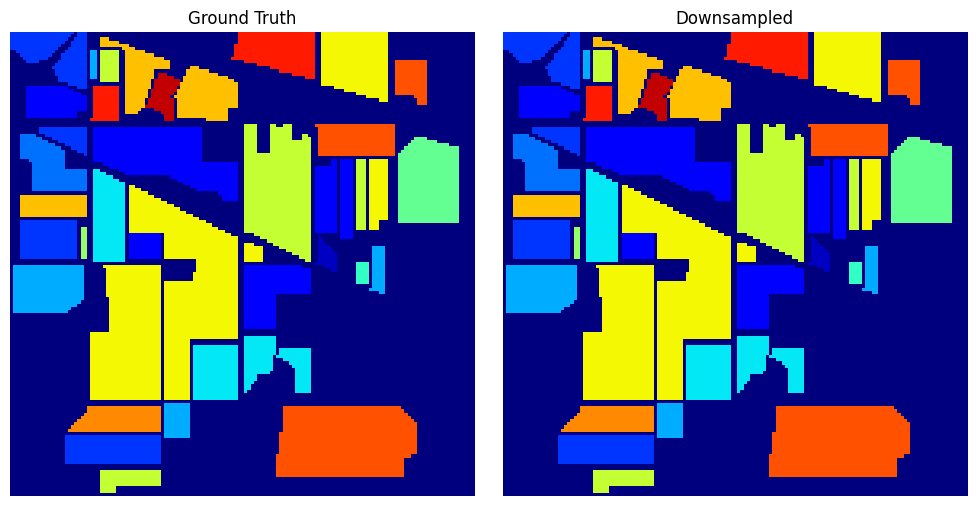

In [10]:
plot_segmentation_comparison(labels, masked_labels, title2="Downsampled")

2. Train model

In [ ]:
k_star = num_classes * k_star_multiplier

# from src.util.over_clustering import linear_over_clustering

# k_values = linear_over_clustering(
#     max_cluster_size=18248, k_star=k_star, max_iter=num_epochs
# )

k_values = exponential_decay_over_clustering(
    k_star=k_star, lambda_v=lambda_v, max_iter=num_epochs
)

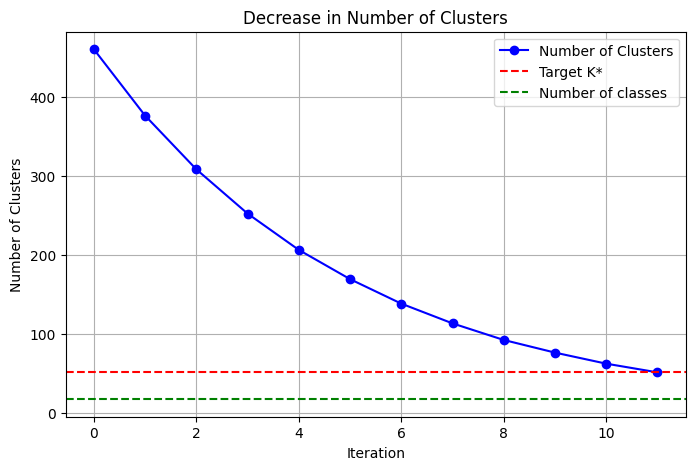

In [12]:
plot_k_values(
    k_values=k_values,
    k_star=k_star,
    num_classes=num_classes
)

In [13]:
model = FullyConvolutionalLeNet(input_channels, num_classes).to(device)

trainer = ClassificationTrainer(
    num_epochs=feature_extractor_epochs,
    learning_rate=learning_rate,
    loss_fun=nn.CrossEntropyLoss(),
)

args = SpatialRegulatedSelfTrainingPipelineArgs(
    num_classes=num_classes,
    cluster_sizes=k_values,
    feature_extractor=CnnFeatureExtractor(
        model, trainer, generator, batch_size=batch_size
    ),
    clustering=KMeansClustering(seed=random_seed),
    splits=splits,
    patch_size=patch_size,
    init_patch_size=5,
    semantic_threshold=semantic_threshold,
    spatial_threshold=8,
    spatial_constraint_weights=[1, 0.5],
    record_step_snapshots=True,
)

pipeline = SpatialRegulatedSelfTrainingPipeline(args, device)

In [ ]:
_, y = pipeline.fit(image, masked_labels, labels)

3. Training results

In [ ]:
plot_segmentation_comparison(labels, y)

In [ ]:
plot_loss(pipeline.history)

In [ ]:
plot_f1_score(pipeline.history)

In [ ]:
plot_overall_accuracy(pipeline.history)

In [ ]:
plot_average_accuracy(pipeline.history)

In [ ]:
plot_kappa(pipeline.history)

In [ ]:
ani = plot_extracted_features_by_epoch(pipeline.history, h, w, num_classes)

HTML(ani.to_jshtml())

In [ ]:
# ani = plot_clusters_by_epoch(pipeline.history, h, w, num_classes)

# HTML(ani.to_jshtml())

In [ ]:
ani = plot_semantic_constraints_by_epoch(pipeline.history, h, w, num_classes)

HTML(ani.to_jshtml())

In [ ]:
ani = plot_merged_semantic_constraint_by_epoch(pipeline.history, h, w, num_classes)

HTML(ani.to_jshtml())

In [ ]:
ani = plot_predictions_by_epoch(pipeline.history, num_classes)

HTML(ani.to_jshtml())